In [96]:
import torch, torchvision
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg11
import numpy as np
from torch.nn import functional as F
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import backpack
from torch.nn import CrossEntropyLoss, Linear
#from utils import load_mnist_data
from backpack import extend, backpack
from backpack.extensions import KFAC
import time
from torch.autograd import Variable
s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [103]:
dataset = CIFAR10(root='~/data/cifar10', download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10(root='~/data/cifar10', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


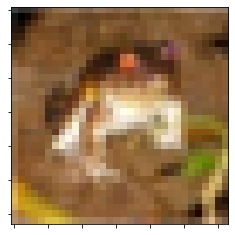

In [104]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))


In [105]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=128*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128*2, num_workers=4, pin_memory=True)

# VGG Network

In [112]:
#pt_vgg11 = vgg11(pretrained=False)
#print(pt_vgg11)
from vgg_pytorch import VGG

pretainedvgg11 = VGG.from_pretrained('vgg11', num_classes=10)
print(pretainedvgg11)


Loaded pretrained weights for vgg11
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, paddi

In [119]:
def VGG11(num_classes=10):
    
    features = torch.nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.AdaptiveAvgPool2d(output_size=(7, 7)),
        nn.Flatten(),
        nn.Linear(512 * 7 * 7, 4096, bias=True),
        nn.ReLU(True),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(4096, 4096, bias=True),
        nn.ReLU(True),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(4096, num_classes, bias=True)
    )
    return(features)

In [123]:
vgg11_model = VGG11()
#print(vgg11_model)
loss_function = nn.CrossEntropyLoss()

cifar10_train_optimizer = torch.optim.Adam(vgg11_model.parameters(), lr=1e-3, weight_decay=5e-4)

VGG_PATH = "../VGGtrained_weights/CIFAR10/CIFAR10_weights_seed={}.pth".format(s)

In [125]:
#try to load pretrained weights into Sequential
weights = pretainedvgg11.state_dict()
vgg11_model.load_state_dict(weights, strict=False)

_IncompatibleKeys(missing_keys=['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '8.weight', '8.bias', '11.weight', '11.bias', '13.weight', '13.bias', '16.weight', '16.bias', '18.weight', '18.bias', '22.weight', '22.bias', '25.weight', '25.bias', '28.weight', '28.bias'], unexpected_keys=['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.11.weight', 'features.11.bias', 'features.13.weight', 'features.13.bias', 'features.16.weight', 'features.16.bias', 'features.18.weight', 'features.18.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [107]:
#TRAINING ROUTINE
...

In [126]:
print(vgg11_model.state_dict())

OrderedDict([('0.weight', tensor([[[[ 0.1413, -0.1236, -0.0574],
          [ 0.0196,  0.1118, -0.1326],
          [-0.1264,  0.0895, -0.1552]],

         [[-0.0313,  0.0203, -0.1244],
          [ 0.1275,  0.1204, -0.0561],
          [ 0.0667, -0.1452, -0.0085]],

         [[ 0.1882, -0.1700,  0.1781],
          [-0.1775,  0.1647, -0.0074],
          [-0.1405,  0.1316,  0.0786]]],


        [[[ 0.1924,  0.1479, -0.0888],
          [ 0.0939, -0.1697, -0.0890],
          [-0.0187,  0.1327,  0.0317]],

         [[ 0.1165,  0.0964, -0.1250],
          [ 0.0040,  0.0661,  0.1505],
          [ 0.1922, -0.1156, -0.1398]],

         [[-0.1582, -0.0011,  0.1536],
          [ 0.0016, -0.0827, -0.1734],
          [-0.0382,  0.0195, -0.0383]]],


        [[[-0.0911,  0.1662,  0.1135],
          [-0.0956, -0.0463, -0.0381],
          [-0.0706,  0.0652,  0.0261]],

         [[-0.0259,  0.0733,  0.1622],
          [-0.0089,  0.1411,  0.0944],
          [ 0.1017,  0.0449, -0.0398]],

         [[ 0.0066